# Analysis of Football Team and Players

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

>This data analysis project works with Football database sourced from Kaggle. The database contains data of matches, players and teams from several European countries from 2008 to 2016. Following are few specifications of the database.

>- +25,000 matches
>- +10,000 players
>- 11 European Countries with their lead championship
>- Seasons 2008 to 2016
>- Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
>- Team line up with squad formation (X, Y coordinates)
>- Betting odds from up to 10 providers
>- Detailed match events (goal types, possession, corner, cross, fouls, cards etc…) for +10,000 matches

> The analysis tries to explore relation between various player, team attributes and their winning chances.
The following questions are tried to be answered.

>- What teams improved the most over the time period?
>- Which players had the most penalties? 
>- What team attributes lead to the most victories?

> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).


In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<a id='wrangling'></a>
## Data Wrangling

### 1. Loading the Sqlite DB as Pandas DataFrame

In [3]:
#Reading datatable names contained in the sqlite DB
con = sqlite3.connect('archive/database.sqlite')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())
con.close()

[('sqlite_sequence',), ('Player_Attributes',), ('Player',), ('Match',), ('League',), ('Country',), ('Team',), ('Team_Attributes',)]


In [4]:
#Importing the sqlite datatables as pandas Dataframe 
con = sqlite3.connect('archive/database.sqlite')
df_sqlite_sqe = pd.read_sql_query("SELECT * from sqlite_sequence", con)
df_P = pd.read_sql_query("SELECT * from Player", con)
df_P_Attr = pd.read_sql_query("SELECT * from Player_Attributes", con)
df_T = pd.read_sql_query("SELECT * from Team", con)
df_T_Attr = pd.read_sql_query("SELECT * from Team_Attributes", con)
df_M = pd.read_sql_query("SELECT * from Match", con)
df_L = pd.read_sql_query("SELECT * from League", con)
con.close()

### 2.1 Player and Player_Attribute Dataset

>The 2 Dataset are merged after preliminary cleaning of individual Datasets
The merged dataset is then analyzed further

### 2.1.1 Player Dataset

In [5]:
df_P.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11060 non-null  int64  
 1   player_api_id       11060 non-null  int64  
 2   player_name         11060 non-null  object 
 3   player_fifa_api_id  11060 non-null  int64  
 4   birthday            11060 non-null  object 
 5   height              11060 non-null  float64
 6   weight              11060 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 605.0+ KB


 ### Observation: 
> Player Dataset appears OK. Following couple of actions are taken:    
    - Datatype of birthday set to Datatime.    
    - Height column set to int.

### Cleaning

In [6]:
df_P.birthday = pd.to_datetime(df_P.birthday)
df_P.height = df_P.height.astype(int)

### 2.1.2 Player_Attribute Dataset

In [7]:
df_P_Attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

 ### Observation

> 1. **Player_Attribute** has higher number of rows(183978) compared to **Player** Dataset(11060). 
 Considering that there are same unique players in the two dataset, this means **Player_Attribute** Dataset has multiple records for individual player. 

> 2. There are major number of rows with missing values. 
>> **a.** Apart from columns representing Player ID and Date, no column had entries higher 183142. The additional rows (183978-183142) will be dropped.  
>> **b.** For columns having non-null rows lesser than 183142: 
>>> - Mean of values from non-null rows of same player is used
>>> - If all rows of the individaul player are nulll, mean value of the dataset(covering all player) is used to fill the dataset.

In [8]:
drop = df_P_Attr[df_P_Attr.overall_rating.isnull()].index
df_P_Attr = df_P_Attr.drop(drop)

### 2.1.3 Merging Player and Player_Attribute

In [9]:
##Player Dataset is merged and Null Values Dropped
df_P_Mer = pd.merge(df_P, df_P_Attr, how='inner', on=['player_api_id','player_fifa_api_id'])
df_P_Mer.drop(['id_x','id_y'], axis=1, inplace=True)

In [10]:
df_P_Mer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183016 entries, 0 to 183015
Data columns (total 45 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   player_api_id        183016 non-null  int64         
 1   player_name          183016 non-null  object        
 2   player_fifa_api_id   183016 non-null  int64         
 3   birthday             183016 non-null  datetime64[ns]
 4   height               183016 non-null  int32         
 5   weight               183016 non-null  int64         
 6   date                 183016 non-null  object        
 7   overall_rating       183016 non-null  float64       
 8   potential            183016 non-null  float64       
 9   preferred_foot       183016 non-null  object        
 10  attacking_work_rate  180622 non-null  object        
 11  defensive_work_rate  183016 non-null  object        
 12  crossing             183016 non-null  float64       
 13  finishing     

- The number of non-null rows for **overall potential** has dropped to 183016 from 183142.  
- The loss of 126 rows is becuase **wrong entries** mismatch of pair of **"player_api_id" & "player_fifa_api_id"** between the merged Datasets.  
- This is verified below.  

In [11]:
x = tuple(zip(df_P.player_api_id, df_P.player_fifa_api_id)) #Pair of api_id & fifa_api_id in "Player Dataset"
y = tuple(zip(df_P_Attr.player_api_id, df_P_Attr.player_fifa_api_id)) #Pair of api_id & fifa_api_id in "Player_Attribute Dataset"
mismatch_1 = [tuple([i,j]) for i,j in x if tuple([i,j]) not in y] # Pair present in Player but missing in Player_Attribute
mismatch_2 = [tuple([i,j]) for i,j in y if tuple([i,j]) not in x] # Pair present in Player_Attribute but missing in Player

In [12]:
print(len(mismatch_1),len(mismatch_2))

0 126


- The true identity of the Players for these 126 rows from Player_Attribute dataset cannot be known.  
- As these number of rows is small compared to the available dataset, these rows left out of analysis.

### Filling the Null rows of the merged Player Dataset

As discussed in the observation of Player_Attribute Dataset, check if there are individaul players with partial rows with Null values.
For such players, mean of their non-null values will be used. This will allow us to be more representative.

In [13]:
columns = df_P_Mer.keys()
null_columns = columns[df_P_Mer.isnull().any()].unique()

match_1 = {}
match_2 = {}

for i in null_columns:
    null_keys = df_P_Mer[df_P_Mer.loc[:,i].isnull()].player_fifa_api_id.unique()
    not_null_keys = df_P_Mer[df_P_Mer.loc[:,i].notnull()].player_fifa_api_id.unique()
    match_11 = [i for i in null_keys if i in not_null_keys]
    match_1[i] = len(match_11)

In [14]:
match_1

{'attacking_work_rate': 0,
 'volleys': 0,
 'curve': 0,
 'agility': 0,
 'balance': 0,
 'jumping': 0,
 'vision': 0,
 'sliding_tackle': 0}

The above indicates that there are no individual players with partially filled rows.  
So the mean from the attributes of all playesrs is used to fill the null values.

In [15]:
temp = df_P_Mer[null_columns]
df_P_Mer[null_columns] = temp.fillna(temp.mean())
df_P_Mer[null_columns] = df_P_Mer[null_columns].fillna('medium')

### Dataset: Team & Team Attribute

In [16]:
df_T.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                299 non-null    int64  
 1   team_api_id       299 non-null    int64  
 2   team_fifa_api_id  288 non-null    float64
 3   team_long_name    299 non-null    object 
 4   team_short_name   299 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


 ### Observation: 
>Team Dataset is good. Doesn't require any cleaning as:
>- No null value rows observed in the "Player" Dataset.
>- All the data types appear to be of the right type.

In [17]:
df_T_Attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1458 non-null   int64  
 1   team_fifa_api_id                1458 non-null   int64  
 2   team_api_id                     1458 non-null   int64  
 3   date                            1458 non-null   object 
 4   buildUpPlaySpeed                1458 non-null   int64  
 5   buildUpPlaySpeedClass           1458 non-null   object 
 6   buildUpPlayDribbling            489 non-null    float64
 7   buildUpPlayDribblingClass       1458 non-null   object 
 8   buildUpPlayPassing              1458 non-null   int64  
 9   buildUpPlayPassingClass         1458 non-null   object 
 10  buildUpPlayPositioningClass     1458 non-null   object 
 11  chanceCreationPassing           1458 non-null   int64  
 12  chanceCreationPassingClass      14

### Observation
> 1. **Team_Attribute** has higher number of rows(1458) compared to **Team** Dataset(299). 
 Considering that the there are same unique Teams in the two dataset, **Team_Attribute** Dataset has multiple records for individual Team.
> 2. **buildUpPlayDribbling** has high number of rows with null values. These rows are filled by:
>> - Mean of values from non-null rows of same Team 
>> - If all rows for a specific team are nulll, mean value of the dataset(covering all Team) 

### 2.1.3 Merging Team and Team_Attribute

In [86]:
##Team Dataset is merged
df_T_Mer = pd.merge(df_T, df_T_Attr, how='inner', on=['team_api_id','team_fifa_api_id'])
df_T_Mer.drop(['id_x','id_y'], axis=1, inplace=True)
df_T_Mer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1457
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   team_api_id                     1458 non-null   int64  
 1   team_fifa_api_id                1458 non-null   float64
 2   team_long_name                  1458 non-null   object 
 3   team_short_name                 1458 non-null   object 
 4   date                            1458 non-null   object 
 5   buildUpPlaySpeed                1458 non-null   int64  
 6   buildUpPlaySpeedClass           1458 non-null   object 
 7   buildUpPlayDribbling            489 non-null    float64
 8   buildUpPlayDribblingClass       1458 non-null   object 
 9   buildUpPlayPassing              1458 non-null   int64  
 10  buildUpPlayPassingClass         1458 non-null   object 
 11  buildUpPlayPositioningClass     1458 non-null   object 
 12  chanceCreationPassing           14

### Filling the Null rows of the merged Team Dataset

As discussed in the observation of Team_Attribute Dataset, check if there are Team with partial rows with Null values.
For such Teams, mean of their non-null values will be used. This will allow us to be more representative.

In [87]:
columns = df_T_Mer.keys()
null_columns = columns[df_T_Mer.isnull().any()].unique()
match_1 = {}
match_2 = {}
for i in null_columns:
    null_keys = df_T_Mer[df_T_Mer.loc[:,i].isnull()].team_fifa_api_id.unique()
    not_null_keys = df_T_Mer[df_T_Mer.loc[:,i].notnull()].team_fifa_api_id.unique()
    match_11 = [i for i in null_keys if i in not_null_keys]
    match_1[i] = len(match_11)

In [88]:
match_1

{'buildUpPlayDribbling': 245}

The above shows that there are 245 teams with partially filled rows.  
We have column **buildUpPlayDribblingClass**. The mean is based on the category of dribbling
Mean per Team_fifa_api_id needs to be calculated for the column **buildUpPlayDribbling**

In [89]:
mean_by_dribbling_class = df_T_Mer.loc[:,['buildUpPlayDribblingClass','buildUpPlayDribbling']].groupby('buildUpPlayDribblingClass', as_index=False).mean()
#mean_by_dribbling_class.set_index()
#df_T_Mer.set_index('team_fifa_api_id', inplace = True)
temp1 = df_T_Mer[df_T_Mer.loc[:,'buildUpPlayDribbling'].isnull()]
df_T_Mer.drop(temp1.index, inplace=True)
temp2 = pd.merge(temp1, mean_by_dribbling_class, left_on='buildUpPlayDribblingClass', right_on='buildUpPlayDribblingClass', how='inner')
temp2.drop(labels='buildUpPlayDribbling_x', axis=1, inplace=True)
temp2.rename(columns={'buildUpPlayDribbling_y':'buildUpPlayDribbling'}, inplace=True)
df_T_Mer = pd.concat([df_T_Mer,temp2])

In [90]:
df_T_Mer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 4 to 968
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   team_api_id                     1458 non-null   int64  
 1   team_fifa_api_id                1458 non-null   float64
 2   team_long_name                  1458 non-null   object 
 3   team_short_name                 1458 non-null   object 
 4   date                            1458 non-null   object 
 5   buildUpPlaySpeed                1458 non-null   int64  
 6   buildUpPlaySpeedClass           1458 non-null   object 
 7   buildUpPlayDribbling            1458 non-null   float64
 8   buildUpPlayDribblingClass       1458 non-null   object 
 9   buildUpPlayPassing              1458 non-null   int64  
 10  buildUpPlayPassingClass         1458 non-null   object 
 11  buildUpPlayPositioningClass     1458 non-null   object 
 12  chanceCreationPassing           145

### Dataset: Match

In [91]:
df_M.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to BSA
dtypes: float64(96), int64(9), object(10)
memory usage: 22.8+ MB


### Observation
Match Dataset has 115 number of columns. Columns name are printed to check which columns are useful.

### Dataset: League

In [98]:
df_L.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11 non-null     int64 
 1   country_id  11 non-null     int64 
 2   name        11 non-null     object
dtypes: int64(2), object(1)
memory usage: 392.0+ bytes


### Data Cleaning (Replace this with more specific notes!)
### After discussing the structure of the data and any problems that need to be
### cleaned, perform those cleaning steps in the second part of this section.

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1: Player Overall Rating Distribution

<AxesSubplot:ylabel='Density'>

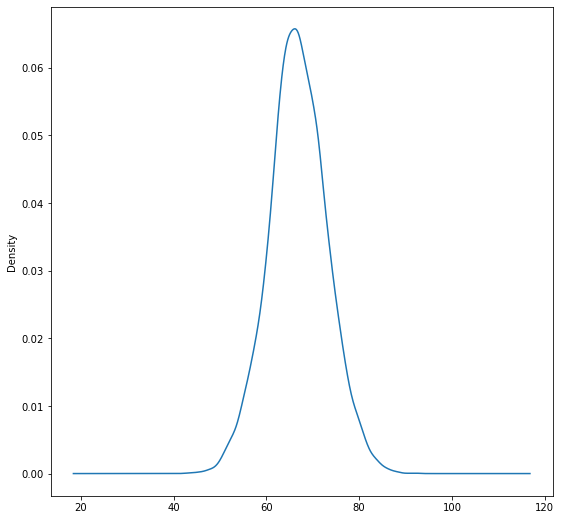

In [108]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
Player_avg = df_P_Mer.groupby('player_fifa_api_id').mean()
%matplotlib inline

Player_avg.overall_rating.plot.kde(figsize=(9,9))

<AxesSubplot:>

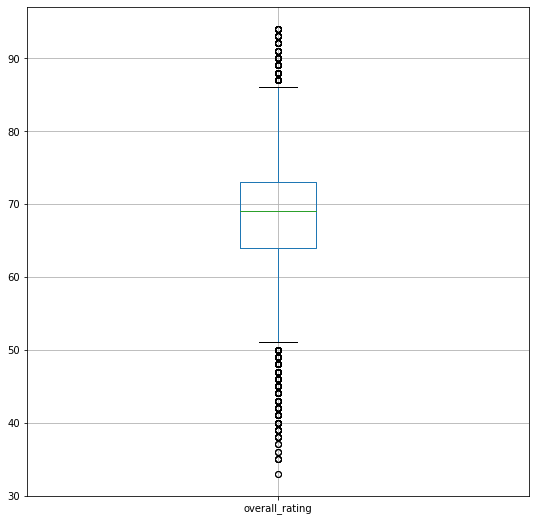

In [109]:
df_P_Mer.boxplot(column=['overall_rating'],figsize=(9,9))

In [110]:
df_P_Mer.overall_rating.quantile(0.99)

84.0

### Research Question 2: What teams improved the most over the time period?

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!